In [0]:
import sys
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

import networkx as nx
import math
import itertools

import collections
import pickle
from sklearn.metrics import mean_squared_error

Helper Functions

getstockdata(): constructs the multivariate lagged dataset to be used in DNN training.

fstat(): calculates the f-statistic as defined in the paper code

construct_graph(): calculates f-stat for rmse_ur and rmse_r and constructs directed granger dependency graph

In [0]:
# returns lagged data set for autoregression training
def getstockdata(dfall, dfout, lag=200):
    Ypast = []
    Ycurr = []

    for i in range(-inputbatchsize, 0):
        y = dfout.iloc[i]
        x = []
        for dfone in dfall:
            x = x + dfall[dfone].iloc[i - lag:i].tolist()
        Ypast.append(x)
        Ycurr.append(y)

    Ypast = np.vstack(Ypast)
    Ycurr = np.vstack(Ycurr)

    Ycurr = Ycurr.reshape(Ycurr.shape[0], )

    return Ypast,Ycurr

# calculates fstat for RMSE
def calc_fstat(rmse_ur, rmse_r):
    return (rmse_r-rmse_ur)/rmse_ur

# constructs directed graph indicating
# granger causal features
def construct_graph(rmse_ur, rmse_r):
    rmse_keys = list(rmse_ur.keys())
    graph_dict = {k:[] for k in rmse_ur}
    #print(graph_dict)
    for k in rmse_keys:
        cand = rmse_ur[k]
        for c in cand:
            fs = calc_fstat(rmse_ur[k][c], rmse_r[k][c])
            if fs > 0.05:
                graph_dict[c].append(k)

    graph_dict = {k:v for (k,v) in graph_dict.items() if v != []}
    G = nx.DiGraph(graph_dict, directed=True)
    return G, graph_dict

In [0]:
# deep learning model for autoregression
def regression_model(lag, ypast_dim1):
    model = Sequential()
    model.add(Dense(units=2*lag, activation='relu', kernel_initializer='normal', bias_initializer='zeros', input_dim=ypast_dim1))
    model.add(Dropout(0.5))
    model.add(Dense(lag/2, activation='linear', kernel_initializer='normal', bias_initializer='zeros'))
    model.add(Dropout(0.2))
    model.add(Dense(lag/2, activation='relu', kernel_initializer='normal', bias_initializer='zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, kernel_initializer='normal', bias_initializer='zeros'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # model.compile(loss='mse', optimizer='adam', metrics=['msd'])
    return model

Data Preprocessing

*cols* variable specifies which columns are to be dropped (all non prices cols except Date)

Also scales data by mean

In [5]:
df = pd.read_csv("/content/drive/My Drive/data/gcf/pricesvolumes.csv")

cols = [1,2,3,4,6,8,10,12,14,16,18,20,21,22,23,24,26,28,30,32,33,34,36,38,40,42]

df.drop(df.columns[cols],axis=1,inplace=True)
df.fillna(0, inplace=True)

print(len(df.columns)) # 17
print((df.columns)) # Index([u'Date', u'^DJI_prices', u'^GSPC_prices', u'^IXIC_prices', u'AAPL_prices', u'ABT_prices', u'AEM_prices', u'AFG_prices', u'APA_prices', u'B_prices', u'CAT_prices', u'FRD_prices', u'GIGA_prices', u'LAKE_prices', u'MCD_prices', u'MSFT_prices', u'ORCL_prices', u'SUN_prices', u'T_prices', u'UTX_prices', u'WWD_prices'], dtype='object')
print(len(df.index)) # 5285

allcols = df.columns.tolist()
print('allcols',allcols[1:])
df[allcols[1:]] = df[allcols[1:]].apply(pd.to_numeric).apply(lambda x: x/x.mean(), axis=0)

allcols.remove("Date")
allcols.remove("IXIC_prices")
allcols.remove("B_prices")
allcols.remove("LAKE_prices")
allcols.remove("SUN_prices")

17
Index(['Date', 'IXIC_prices', 'AAPL_prices', 'ABT_prices', 'AEM_prices',
       'AFG_prices', 'APA_prices', 'B_prices', 'CAT_prices', 'LAKE_prices',
       'MCD_prices', 'MSFT_prices', 'ORCL_prices', 'SUN_prices', 'T_prices',
       'UTX_prices', 'WWD_prices'],
      dtype='object')
5285
allcols ['IXIC_prices', 'AAPL_prices', 'ABT_prices', 'AEM_prices', 'AFG_prices', 'APA_prices', 'B_prices', 'CAT_prices', 'LAKE_prices', 'MCD_prices', 'MSFT_prices', 'ORCL_prices', 'SUN_prices', 'T_prices', 'UTX_prices', 'WWD_prices']


Loads fstat and rmse of bivariate regression models (computed previously)

Constructs network graph & draws it

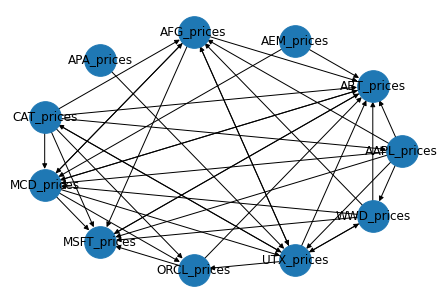

In [8]:
# Parameters for autoregression model & algorithm
inputbatchsize = 5000

# time lags for restricted and unrestricted models
p = 200
q = 200

numepochs = 50

# model results are saved in dict format
# every stock has one key entry 
Rmse_ur_mv = "/content/drive/My Drive/models/rmse_ur_mv.pkl"
Fstat_ur_mv = "/content/drive/My Drive/models/fstat_ur_mv.pkl"
rmse_urPath = "/content/drive/My Drive/models/msemodelurrmse.pkl"
rmse_rPath = "/content/drive/My Drive/models/msemodelrrmse.pkl"
handle = open(rmse_urPath, 'rb')
rmse_ur_bv = pickle.load(handle)
handle = open(rmse_rPath, 'rb')
rmse_r_bv = pickle.load(handle)

G, g_dict = construct_graph(rmse_ur_bv,rmse_r_bv)

options = {
  'node_size': 1000,'width': 1,'arrowstyle': '-|>','arrowsize': 10,
}

pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, **options)

effect = ["S1"]

effect.predecessors = ["A","B","C", "D"]

onecauses = ["A","B","C", "D"]

candidates = ["AB", "AC", "AD", "BC", "BD", "CD"]

if "AB" and "BC" are viable candidates, next iterations cand will be:

candidates = ["ABC", "ABD", "BCD"]


In [12]:
rmse_ur_mv = collections.defaultdict(dict)
fstat_ur_mv = collections.defaultdict(dict)

# adds every node in the graph that has predecessors
# to the list of effects
effects = []
for effect in sorted(G.nodes()):
    predecessors = list(G.predecessors(effect))
    if(predecessors):
        effects.append(effect)

print('effects',effects)

# delete ABT_prices, UTX_prices for testing
#del effects[1], effects[-1]

effects1 = ['ABT_prices']
#for effect in effects: 
# only look at one stock for testing purpose one stock
for effect in effects1:
    print("Effect: ", effect)
    # generates a list of all the predecessors of the current effect
    # to perform a branch and bound type permutation of possible 
    # multivariate causes
    one_causes = list(zip([col for col in G.predecessors(effect)])) # all bivariate granger causal features
    if one_causes:
        firstiter = 0
        maximal_causes = one_causes
        #all_causes = powerset(one_causes)
        while maximal_causes:
            firstiter += 1
            candidatecauseslist = list(prod for prod in itertools.product(one_causes, maximal_causes) if prod[0][0] not in prod[1])
            #print('candidatecauseslist',candidatecauseslist)
            #print('onecauses',one_causes)
            #print('maximalcauses',maximal_causes)
            maximal_causes = []
            for candidatecauses in candidatecauseslist:
                stockcauses = []
                for c in candidatecauses:
                    for uc in c:
                        stockcauses.append(uc)
                #print('candidatecauses',candidatecauses)
                stockcauses = list(filter(None, stockcauses))
                #print(stockcauses)

                if(firstiter == 1) :
                    restrictederror = rmse_ur_bv[effect][stockcauses[0]]
                else:
                    restrictederror = rmse_ur_mv[effect][tuple(sorted(stockcauses[1:]))]
                #print('restrictederror',restrictederror)
                Ypast, Ycurr = getstockdata(df[stockcauses], df[effect])

                numrecords = len(Ycurr)
                numtestrecords = int(math.ceil(0.3 * numrecords))
                numtrainrecords = int(math.ceil(0.7 * numrecords))
                
                model_ur = regression_model(q, Ypast.shape[1])
                np.random.seed(7)
                model_ur.fit(Ypast[:numtrainrecords], Ycurr[:numtrainrecords], epochs=numepochs, batch_size=32, verbose=0, validation_split=0.1)
                Ycurrp = model_ur.predict(Ypast[-numtestrecords:], batch_size=128)
                unrestrictederror = math.sqrt(mean_squared_error(Ycurrp, Ycurr[-numtestrecords:]))
                # TO DO : Save unrestrictederror in dict
                #print('unrestrictederror',unrestrictederror)
                #fstat = (restrictederror - unrestrictederror) / unrestrictederror
                fstat = calc_fstat(unrestrictederror, restrictederror)
                #print('-------------------------------')
                #print('stockcauses',stockcauses)
                #print('fstat',fstat)
                #print('-------------------------------')
                if ( fstat > 0.05 ):
                    founddup = False
                    for maximalcause in maximal_causes:
                        if sorted(list(maximalcause)) == sorted(stockcauses):
                            founddup = True
                    if(not founddup):
                        maximal_causes.append(tuple(sorted(stockcauses)))
                        rmse_ur_mv[effect][tuple(sorted(stockcauses))] = unrestrictederror
                        fstat_ur_mv[effect][tuple(sorted(stockcauses))] = fstat
                    print('maximalcauses',maximal_causes)  
print(rmse_ur_mv)
print(fstat_ur_mv)

Rmse_ur_mv = "/content/drive/My Drive/models/rmse_ur_mv.pkl"
Fstat_ur_mv = "/content/drive/My Drive/models/fstat_ur_mv.pkl"

with open(Rmse_ur_mv, 'wb') as handle:
    pickle.dump(rmse_ur_mv, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(Fstat_ur_mv, 'wb') as handle:
    pickle.dump(fstat_ur_mv, handle, protocol=pickle.HIGHEST_PROTOCOL)


effects ['AAPL_prices', 'ABT_prices', 'AFG_prices', 'CAT_prices', 'MCD_prices', 'MSFT_prices', 'ORCL_prices', 'UTX_prices', 'WWD_prices']
Effect:  ABT_prices
maximalcauses [('AAPL_prices', 'AEM_prices')]
maximalcauses [('AAPL_prices', 'AEM_prices'), ('AEM_prices', 'WWD_prices')]
maximalcauses [('AAPL_prices', 'AEM_prices'), ('AEM_prices', 'WWD_prices'), ('AAPL_prices', 'AFG_prices')]
maximalcauses [('AAPL_prices', 'AEM_prices'), ('AEM_prices', 'WWD_prices'), ('AAPL_prices', 'AFG_prices'), ('AAPL_prices', 'CAT_prices')]
maximalcauses [('AAPL_prices', 'AEM_prices'), ('AEM_prices', 'WWD_prices'), ('AAPL_prices', 'AFG_prices'), ('AAPL_prices', 'CAT_prices'), ('AAPL_prices', 'MSFT_prices')]
maximalcauses [('AAPL_prices', 'AFG_prices', 'MSFT_prices')]
maximalcauses [('AAPL_prices', 'AFG_prices', 'MSFT_prices'), ('AAPL_prices', 'AEM_prices', 'CAT_prices')]
maximalcauses [('AAPL_prices', 'AFG_prices', 'MSFT_prices'), ('AAPL_prices', 'AEM_prices', 'CAT_prices'), ('AEM_prices', 'CAT_prices', 'WW